# **Chatbot Admissão Unicamp 2024 - Model Validation**

## Generating data from ChatGPT

The initial approach was to automate the test set creation process by using the ChatGPT API through a [script](https://github.com/vitorpaziam/Chatbot-Vestibular-Unicamp/blob/main/generate_testset.py) to perform queries, creating a CSV file that paired each question with its expected answer based on the content of each *chunk* of the text from the [Resolução GR-031/2023](https://www.pg.unicamp.br/norma/31594/0).
However, the *script* was unable to generate a sufficient amount of data due to extended execution times leading to timeouts. Consequently, the ChatGPT's interface was employed for data generation, enabling the *manual creation* of the test set through message-based interactions. General structure of the messages and responses that formed the [test set](https://github.com/vitorpaziam/Chatbot-Vestibular-Unicamp/blob/main/dataset/testset_direct.csv) (In Portuguese):

- Message:
> Para as próximas solicitações, se comporte como um assistente que deve fazer perguntas e responder perguntas sobre o processo de Admissão na Unicamp 2024. Escreva em formato tabular uma tabela com as colunas 'generated_question' e 'generated_answer' em que cada linha coloque uma pergunta direta e objetiva e a resposta dessa pergunta em que as informações estão contidas e se baseiam no conteúdo do trecho do Edital da Unicamp 2024: {trecho}

- ChatGPT's answer:

<center>

| generated_question |  generated_answer  |
| :----------------: | :----------------: |
| {pergunta_gerada1} | {resposta_gerada1} |
| {pergunta_gerada2} | {resposta_gerada2} |
| {pergunta_gerada3} | {resposta_gerada3} |
| ... | ... |

</center>




## Testing the model

The methodology employed to evaluate the model consisted of iterating through the *test set* file, inputting the `generated_questio` into the model, and subsequently comparing the model's output with the expected response in `generated_answer`. This comparison was achieved utilizing the *TF-IDF vectorizer* and *cosine similarity* (ChatGPT's recommendation). Each comparison generated a score within the range of `[0..1000]`, where higher values denoted a greater degree of similarity between the responses.

<center>

<img src="https://miro.medium.com/v2/resize:fit:824/1*GK56xmDIWtNQAD_jnBIt2g.png" alt="Cosine Similarity Schema" width="600"/>

</center>

From the [model testing code](https://github.com/vitorpaziam/Chatbot-Vestibular-Unicamp/blob/main/model_testing.py), two new columns, `model_answer` and `model_answer_score`, were created to store these results for each row. Subsequently, a new file was generated, containing the [test outcomes](https://github.com/vitorpaziam/Chatbot-Vestibular-Unicamp/blob/main/dataset/testset_direct_with_model_answers.csv).


## Analysis of the model's test data

Loading the CSV file data with the test results into a Pandas `DataFrame`.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

url = "https://raw.githubusercontent.com/vitorpaziam/Chatbot-Vestibular-Unicamp/main/dataset/testset_direct_with_model_answers.csv"
data = pd.read_csv(url)

data.head()

,generated_question,generated_answer,model_answer,model_answer_score
0,Qual é o objetivo do Vestibular Unicamp 2024?,O VU 2024 tem por objetivos: I. Classificar e ...,O objetivo do Vestibular Unicamp 2024 é classi...,828
1,Quais são os critérios de avaliação no Vestibu...,"Para alcançar os objetivos estabelecidos, o VU...",Os critérios de avaliação no Vestibular Unicam...,952
2,Quem pode se inscrever no Vestibular Unicamp 2...,Poderá se inscrever no VU 2024 o(a) candidato(...,Os requisitos para se inscrever no Vestibular ...,911
3,Quantas vagas são oferecidas pelo Vestibular U...,São oferecidas 2537 vagas pelo Vestibular Unic...,O Vestibular da Unicamp 2024 oferece 2537 vaga...,1000
4,Onde posso encontrar informações sobre o Vesti...,"O Manual do Ingresso, contendo todas as inform...",Você encontra informações sobre o Vestibular U...,987


Setting the desired similarity threshold and calculating the model's accuracy based on the `model_answer_score` values.

In [ ]:
threshold = 600

accurate_predictions = data[data['model_answer_score'] >= threshold]
accuracy = len(accurate_predictions) / len(data) * 100

print(f"Model accuracy: {accuracy:.2f}%")

Model accuracy: 80.00%


Visualizing the distribution of similarity scores.

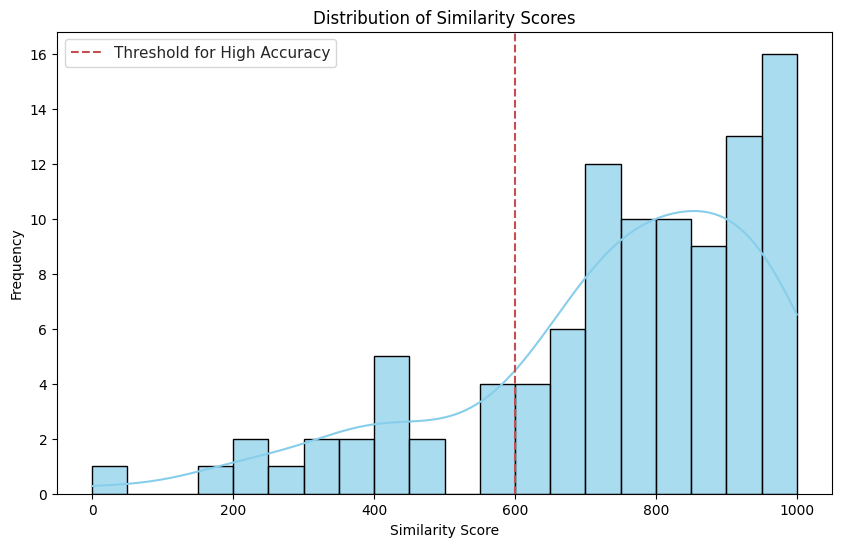

In [ ]:
plt.figure(figsize = (10, 6))
sns.histplot(data['model_answer_score'], kde = True, bins = 20, color = 'skyblue', edgecolor = 'black', alpha = 0.7)
sns.set(style = 'whitegrid')

# Add title and labels
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')

# Add threshold line
plt.axvline(x = threshold, color = 'r', linestyle = '--', label = 'Threshold for High Accuracy')
plt.legend()

plt.show()

Identifying and displaying cases with low `model_answer_score`, in order to understand the weaknesses and vulnerabilities of the model.

In [ ]:
not_accurate_predictions = data[data['model_answer_score'] < threshold]
not_accurate_predictions = not_accurate_predictions.sort_values(by = 'model_answer_score', ascending = False)

# Showing the set of not accurated predictions
if not not_accurate_predictions.empty:
  for index, row in not_accurate_predictions.iterrows():
    print(f"{index} -> Question: {row['generated_question']}")
    print(f"{index} -> Expected answer: {row['generated_answer']}")
    print(f"{index} -> Model answer: {row['model_answer']}")
    print(f"{index} -> Model score: {row['model_answer_score']}")
    print() # Break line
else:
  print("No prediction was considered not accurated!")

## Conclusions

The model exhibited a satisfactory accuracy of __*80%*__. However, this value is subject to some *inaccuracy* due to factors such as:

**1. Data Used for Model Testing**

The choice of questions for model testing significantly impacts its performance. In this test, the ChatGPT was prompted to generate direct and objective questions based on specific excerpts from the 2024 Unicamp Edital. Using a test set that includes interpretative or conversational questions, i.e. questions related to previous ones, may result in varying accuracy outcomes. Furthermore, it is crucial to consider potential errors in the responses generated by ChatGPT, which will be used as expected answers for the model during the validation phase.

**2. Model Validation Method**

The method *TF-IDF (Term Frequency-Inverse Document Frequency)* used for vectorization assigns weights to words based on their occurrence in a document compared to a larger corpus. *Cosine similarity* measures the similarity between vectors, aiding in the evaluation of semantic resemblance. However, due to the complexities of language, even with shared words, nuanced differences in context and meaning can occasionally lead to inconsistencies in results, particularly when comparing the expected and model answers. Some examples of inaccuracies associated with this method of validating model are:

- High similarity score, as the `Model answer` contains similar words to the `Expected answer`. However, it implies divergent responses:

>**testset_direct_with_model_answers.csv Index 23**
<br>**-> Question:** Existe a possibilidade de permuta de vagas entre candidatos?
<br>**-> Expected answer:** Não, a permuta de vagas entre candidatos classificados não é permitida.
<br>**-> Model answer:** Não há informações disponíveis no texto que indiquem a possibilidade de realizar permuta de vagas entre os candidatos convocados.
<br>**-> Model score:** 804

- Low similarity score with suitable and correct `Model answer` for `Question`:

>**testset_direct_with_model_answers.csv Index 31**
<br>**-> Question:** Quantas questões objetivas compõem a prova da primeira fase?
<br>**-> Expected answer:** A prova da primeira fase é composta por 72 questões objetivas distribuídas da seguinte forma: 12 questões de Matemática, 12 questões de Língua Portuguesa e Literaturas de Língua Portuguesa, 7 questões de Inglês, 21 questões de Ciências da Natureza (Biologia, Química e Física) e 20 questões de Ciências Humanas (História, Geografia, Filosofia e Sociologia).	<br>**-> Model answer:** A prova da primeira fase é composta por 72 questões objetivas.
<br>**-> Model score:** 485

- Low similarity score between the `Model answer` and the `Expected answer`, as `Model answer` is in English:

>**testset_direct_with_model_answers.csv Index 69**
<br>**-> Question:** Quais são os cursos de Música oferecidos no Vestibular Unicamp 2024?
<br>**-> Expected answer:** Os cursos de Música oferecidos no Vestibular Unicamp 2024 incluem Música Popular (Piano, Voz, Saxofone, Contrabaixo, Guitarra, Bateria, Violão) e Música Erudita (Clarineta, Flauta, Trombone, Viola, Contrabaixo, Violoncelo, Percussão, Voz, Piano, Trompete, Violino) além de Música: Licenciatura, Música Erudita: Composição e Música Erudita: Regência.	<br>**-> Model answer:** The music courses offered in the Unicamp 2024 entrance exam are: Bachelor's Degree: - Popular Music: Piano - 2 vacancies; - Popular Music: Voice - 2 vacancies; - Popular Music: Saxophone - 2 vacancies; - Popular Music: Double Bass - 2 vacancies; - Popular Music: Guitar - 2 vacancies; - Popular Music: Drums - 2 vacancies; - Popular Music: Guitar - 1 vacancy. Bachelor's Degree: - Classical Music: Clarinet - 3 vacancies; - Classical Music: Flute - 3 vacancies; - Classical Music: Trombone - 3 vacancies; - Classical Music: Viola - 2 vacancies; - Classical Music: Double Bass - 2 vacancies; - Classical Music: Guitar - 2 vacancies; - Classical Music: Cello - 2 vacancies; - Classical Music: Percussion - 2 vacancies; - Classical Music: Voice - 2 vacancies; - Classical Music: Piano - 3 vacancies; - Classical Music: Trumpet - 2 vacancies; - Classical Music: Violin - 2 vacancies. Music: Teaching Degree - 14 vacancies.
<br>**-> Model score:** 214

**3. Threshold Definition**

The selection of the threshold value has a direct impact on the model's accuracy. The aim in defining this value is to find a threshold that represents a subtle division between responses with good and poor accuracies. In this study, setting the valu `threshold = 600` proved to be appropriate, as demonstrated by the examples of results:

- Model generates a correct but incomplete response, consequently, it isn't considered as an `accurate_prediction`:

> **testset_direct_with_model_answers.csv Index 47**
<br>**-> Question:** Quais são as habilidades exigidas na prova de Filosofia?
<br>**-> Expected answer:** 1. Analisar os textos filosóficos levando em consideração o contexto histórico, o contexto filosófico, as teses e os argumentos apresentados. 2. Compreender e interpretar de forma crítica textos filosóficos produzidos em diferentes épocas e lugares, relacionando-os com temas e questões contemporâneas relevantes, bem como com conhecimentos produzidos em outras áreas. 3. Comparar distintas abordagens filosóficas de um mesmo tema ou conceito à luz da história da filosofia. 4. Elaborar respostas escritas que envolvam descrição, exposição e argumentação com base nas informações e conhecimentos listados no conteúdo programático de Filosofia.
<br>**-> Model answer:** As habilidades exigidas na prova de Filosofia são:
\- Elaborar respostas escritas que envolvam descrição, exposição e argumentação com base nas informações e conhecimentos listados no conteúdo programático de Filosofia.
<br>**-> Model score:** 567

- The model provides a correct response to the question, athough with additional content beyond the expected response. Therefore, it is considered an `accurate_prediction`:

> **testset_direct_with_model_answers.csv Index 7**
<br>**-> Question:** Qual é a proporção mínima de vagas regulares reservada para candidatos autodeclarados pretos e pardos?
<br>**-> Expected answer:** Os candidatos autodeclarados pretos e pardos concorrerão a uma proporção mínima de 15% das vagas regulares em cada curso, ou, se for o caso, até 27,2% das vagas, conforme o Anexo III.
<br>**-> Model answer:** A proporção mínima de vagas reservadas para candidatos autodeclarados pretos e pardos no Vestibular Unicamp 2024 é de 15% das vagas regulares em cada curso, podendo chegar a 27,2% se houver candidatos de 1ª opção que atendam aos critérios de Nota Mínima de Opção (NMO) do respectivo curso.
<br>**-> Model score:** 662